# Online Adaptive Forecasting

In [1]:
%load_ext autoreload
%autoreload 2

import re
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import trajdata.visualization.vis as trajdata_vis

from torch.utils import data
from tqdm.notebook import tqdm
from trajectron.model.model_registrar import ModelRegistrar
from trajectron.model.model_utils import UpdateMode
from trajectron.model.trajectron import Trajectron
from collections import defaultdict
from pathlib import Path
from typing import DefaultDict, Dict, Final, List, Optional, Union
from trajdata import UnifiedDataset, AgentType, AgentBatch

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [2]:
# Change this to suit your computing environment and folder structure!

TRAJDATA_CACHE_DIR: Final[str] = "/home/bivanovic/.unified_data_cache"
LYFT_SAMPLE_RAW_DATA_DIR: Final[str] = "/home/bivanovic/datasets/lyft/scenes/sample.zarr"

In [3]:
base_model = "models/nusc_mm_base_tpp-11_Sep_2022_19_15_45"
k0_model = "models/nusc_mm_k0_tpp-12_Sep_2022_00_40_16"
adaptive_model = "models/nusc_mm_sec4_tpp-13_Sep_2022_11_06_01"
oracle_model = "models/lyft_mm_base_tpp-11_Sep_2022_18_56_49"

base_checkpoint = 20
k0_checkpoint = 20
adaptive_checkpoint = 20
oracle_checkpoint = 1

eval_data = "lyft_sample-mini_val"

history_sec = 2.0
prediction_sec = 6.0

In [4]:
AXHLINE_COLORS = {
    "Base": "#DD9787",
    "K0": "#A6C48A",
    "Oracle": "#A2999E"
}

SEABORN_PALETTE = {
    "Finetune": "#AA7C85",
    "K0": "#A6C48A",
    "Ours+Finetune": "#2D93AD",
    "Ours": "#9F9FED",
    "Base": "#DD9787",
    "K0+Finetune": "#67934D",
    "Oracle": "#A2999E"
}

In [5]:
def load_model(model_dir: str, device: str, epoch: int = 10, custom_hyperparams: Optional[Dict] = None):
    save_path = Path(model_dir) / f'model_registrar-{epoch}.pt'

    model_registrar = ModelRegistrar(model_dir, device)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)
        
    if custom_hyperparams is not None:
        hyperparams.update(custom_hyperparams)

    trajectron = Trajectron(model_registrar, hyperparams, None, device)
    trajectron.set_environment()
    trajectron.set_annealing_params()

    checkpoint = torch.load(save_path, map_location=device)
    trajectron.load_state_dict(checkpoint["model_state_dict"], strict=False)

    return trajectron, hyperparams

In [6]:
if torch.cuda.is_available():
    device = 'cuda:0'
    torch.cuda.set_device(0)
else:
    device = 'cpu'

In [7]:
adaptive_trajectron, hyperparams = load_model(
    adaptive_model, device, epoch=adaptive_checkpoint,
    custom_hyperparams={"trajdata_cache_dir": TRAJDATA_CACHE_DIR,
                        "single_mode_multi_sample": True}
)

# Load training and evaluation environments and scenes
attention_radius = defaultdict(lambda: 20.0) # Default range is 20m unless otherwise specified.
attention_radius[(AgentType.PEDESTRIAN, AgentType.PEDESTRIAN)] = 10.0
attention_radius[(AgentType.PEDESTRIAN, AgentType.VEHICLE)] = 20.0
attention_radius[(AgentType.VEHICLE, AgentType.PEDESTRIAN)] = 20.0
attention_radius[(AgentType.VEHICLE, AgentType.VEHICLE)] = 30.0

map_params = {"px_per_m": 2, "map_size_px": 100, "offset_frac_xy": (-0.75, 0.0)}

online_eval_dataset = UnifiedDataset(
    desired_data=[eval_data],
    # desired_dt=0.5,
    history_sec=(0.1, history_sec),
    future_sec=(prediction_sec, prediction_sec),
    agent_interaction_distances=attention_radius,
    incl_robot_future=hyperparams['incl_robot_node'],
    incl_raster_map=hyperparams['map_encoding'],
    raster_map_params=map_params,
    only_predict=[AgentType.VEHICLE],
    no_types=[AgentType.UNKNOWN],
    num_workers=0,
    cache_location=TRAJDATA_CACHE_DIR,
    data_dirs={
        "lyft_sample": LYFT_SAMPLE_RAW_DATA_DIR,
    },
    verbose=True
)

batch_eval_dataset = UnifiedDataset(
    desired_data=[eval_data],
    # desired_dt=0.5,
    history_sec=(history_sec, history_sec),
    future_sec=(prediction_sec, prediction_sec),
    agent_interaction_distances=attention_radius,
    incl_robot_future=hyperparams['incl_robot_node'],
    incl_raster_map=hyperparams['map_encoding'],
    raster_map_params=map_params,
    only_predict=[AgentType.VEHICLE],
    no_types=[AgentType.UNKNOWN],
    num_workers=0,
    cache_location=TRAJDATA_CACHE_DIR,
    data_dirs={
        "lyft_sample": LYFT_SAMPLE_RAW_DATA_DIR,
    },
    verbose=True
)

Loading data for matched scene tags: ['mini_val-lyft_sample-palo_alto']


Calculating Agent Data (Serially): 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 49373.80it/s]


20 scenes in the scene index.


Structuring Agent Data Index: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 23405.71it/s]

Loading data for matched scene tags: ['mini_val-lyft_sample-palo_alto']



Calculating Agent Data (Serially): 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 50594.74it/s]


20 scenes in the scene index.


Structuring Agent Data Index: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21503.74it/s]


In [8]:
def get_dataloader(
    eval_dataset: UnifiedDataset,
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = False
):
    return data.DataLoader(
        eval_dataset,
        collate_fn=eval_dataset.get_collate_fn(pad_format="right"),
        pin_memory=False if device == 'cpu' else True,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )

In [9]:
metrics_list = ["ml_ade", "ml_fde", "nll_mean", "min_ade_5", "min_ade_10"]

## Online (Per Agent) Plotting

In [10]:
import matplotlib.patches as patches
from scipy import linalg

prog = re.compile("(.*)/(?P<scene_name>.*)/(.*)$")

def plot_outputs(
    eval_dataset: UnifiedDataset,
    dataset_idx: int,
    model: Trajectron,
    model_name: str,
    agent_ts: int,
    save=True,
    extra_str=None,
    subfolder="",
    filetype="png"
):
    num_modes = 5
    plot_every = 1
    plot_square_radius = 75
    pred_horizon = 30
    batch: AgentBatch = eval_dataset.get_collate_fn(pad_format="right")([eval_dataset[dataset_idx]])
    batch_idx = 0

    fig, ax = plt.subplots(dpi=150)
    # NOTE: To exactly reproduce the figure from our paper, you must edit the trajdata_vis.plot_agent_batch function
    # to accept an optional future_horizon (int) argument which truncates plotting to only the future future_horizon timesteps
    # (otherwise it can be a but hard to read the figure when full-length predictions and futures are plotted).
    # After making the above change, please add future_horizon=pred_horizon to the plot_agent_batch arguments.
    trajdata_vis.plot_agent_batch(batch, batch_idx=batch_idx, ax=ax, show=False, close=False)

    scene_info_path, _, scene_ts = eval_dataset._data_index[dataset_idx]
    scene_name = prog.match(scene_info_path).group("scene_name")
    
    agent_name = batch.agent_name[0]
    agent_type_name = f"{str(AgentType(batch.agent_type[0].item()))}/{agent_name}"
    print(dataset_idx, scene_name, scene_ts, agent_type_name)

    with torch.no_grad():
        predictions = model.predict(batch,
                                    z_mode=True,
                                    gmm_mode=True,
                                    full_dist=False,
                                    output_dists=False)
        prediction = next(iter(predictions.values()))
        
        prediction_distribution_dict, _ = model.predict(batch,
                                      z_mode=False,
                                      gmm_mode=False,
                                      full_dist=True,
                                      output_dists=True)
        pred_dist = next(iter(prediction_distribution_dict.values()))
    
    pi_threshold = 0.0
    
    batch.to("cpu")
        
    if pred_dist.mus.shape[:2] != (1, 1):
        return

    means = pred_dist.mus[batch_idx, 0].cpu().numpy()
    covs = pred_dist.get_covariance_matrix()[batch_idx, 0].cpu().numpy()
    pis = pred_dist.pis_cat_dist.probs[batch_idx, 0].cpu().numpy()

    ax.plot(
        prediction[batch_idx, 0:pred_horizon:plot_every, 0],
        prediction[batch_idx, 0:pred_horizon:plot_every, 1],
        color='#2D93AD',
        alpha=1,
        label="Most Likely"
    )
    
    for z_val in range(min(num_modes, means.shape[1])):
        # All pis are the same across time.
        pi = pis[0, z_val]
        
        if pi < pi_threshold:
            continue

        color = '#9F9FED'

        alpha_val = pi
        ax.plot(means[0:pred_horizon:plot_every, z_val, 0], means[0:pred_horizon:plot_every, z_val, 1],
                    color=color,
                    alpha=alpha_val)

        for timestep in range(0, min(pred_horizon, means.shape[0]), plot_every):
            mean = means[timestep, z_val]
            covar = covs[timestep, z_val]

            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan2(u[1], u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = patches.Ellipse(mean, v[0], v[1], 180. + angle,
                                    color=color)
            ell.set_edgecolor(None)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha_val)
            ax.add_artist(ell)
    
    # batch_eval: Dict[str, torch.Tensor] = evaluation.compute_batch_statistics_pt(
    #     batch.agent_fut[..., :2],
    #     prediction_output_dict=torch.from_numpy(prediction),
    #     y_dists=pred_dist
    # )
    
    ax.set_title(None)
    # ax.set_title(f"{scene_name}/t={scene_ts} {agent_type_name}")
    offset = 20
    ax.set_xlim((-plot_square_radius+offset, plot_square_radius+offset))
    ax.set_ylim((-plot_square_radius, plot_square_radius))
    # ax.set_aspect('auto')
    
    ax.axis('off')
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_xlabel(None)
    # ax.set_ylabel(None)
    
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="best", borderaxespad=0, frameon=False)
    # print(model_name, extra_str, batch_eval)
    
    if save:
        fname = f"figures/{subfolder}{model_name}_{scene_name}_{agent_name}_t{agent_ts}"
        if extra_str:
            fname += "_" + extra_str
        fig.savefig(fname + f".{filetype}", bbox_inches="tight")
        
        plt.close(fig)

In [11]:
def per_agent_plot(
    model: Trajectron,
    model_name: str,
    batch: AgentBatch,
    agent_ts: int,
    plot=True,
):
    with torch.no_grad():
        if plot:
            plot_outputs(online_eval_dataset,
                         dataset_idx=batch.data_idx[0].item(),
                         model=model,
                         model_name=model_name,
                         agent_ts=agent_ts)

Adaptive Eval PH=6.0:   0%|          | 0/1001 [00:00<?, ?it/s]

0 scene-0007 1 AgentType.VEHICLE/ego
1 scene-0007 2 AgentType.VEHICLE/ego
2 scene-0007 3 AgentType.VEHICLE/ego
3 scene-0007 4 AgentType.VEHICLE/ego
4 scene-0007 5 AgentType.VEHICLE/ego
5 scene-0007 6 AgentType.VEHICLE/ego
6 scene-0007 7 AgentType.VEHICLE/ego


KeyboardInterrupt: 

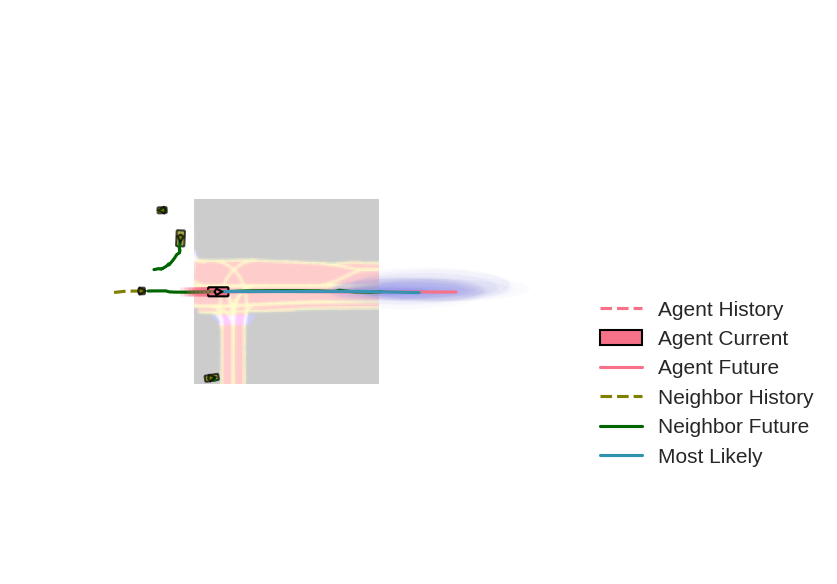

In [12]:
online_eval_dataloader = get_dataloader(online_eval_dataset, batch_size=1, shuffle=False)

adaptive_trajectron.reset_adaptive_info()

N_SAMPLES = 1001

outer_pbar = tqdm(
    online_eval_dataloader,
    total=min(N_SAMPLES, len(online_eval_dataloader)),
    desc=f'Adaptive Eval PH={prediction_sec}',
    position=0,
)

plot_per_step = True

curr_agent: str = None
agent_ts: int = 0
online_batch: AgentBatch
for data_sample, online_batch in enumerate(outer_pbar):
    if data_sample >= N_SAMPLES:
        outer_pbar.close()
        break
            
    if online_batch.agent_name[0] != curr_agent:
        # Resetting the K_n, L_n for each Bayesian last layer.
        adaptive_trajectron.reset_adaptive_info()
        
        # # Resetting the finetune baseline to its base.
        # finetune_trajectron, _ = load_model(
        #     base_model, device, epoch=base_checkpoint,
        #     custom_hyperparams={"trajdata_cache_dir": "/home/bivanovic/.unified_data_cache",
        #                         "single_mode_multi_sample": False}
        # )
        # k0_finetune_trajectron, _ = load_model(
        #     k0_model, device, epoch=k0_checkpoint,
        #     custom_hyperparams={"trajdata_cache_dir": "/home/bivanovic/.unified_data_cache",
        #                         "single_mode_multi_sample": False}
        # )

        curr_agent = online_batch.agent_name[0]
        agent_ts: int = 0
        
    with torch.no_grad():
        # This is the inference call that internally updates L_n and K_n.
        adaptive_trajectron.adaptive_predict(
            online_batch,
            update_mode=UpdateMode.ITERATIVE
        )
    
    # finetune_update(finetune_trajectron, online_batch)
    # finetune_last_layer_update(k0_finetune_trajectron, online_batch)
    
    # # This is effectively measuring number of updates/observed data points.
    # agent_ts += 1
    
    if agent_ts % 1 == 0:
        per_agent_plot(adaptive_trajectron, "Ours", online_batch, agent_ts, plot=plot_per_step)
            
    # This is effectively measuring the most-recently seen timestep.
    agent_ts += 1